In [229]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Mecab
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from collections import Counter

In [230]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x32ea70a90>)

In [231]:
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')
print('훈련용 개수: ', len(train_data))

훈련용 개수:  150000


In [232]:
train_data[:5]

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [233]:
print('테스트용 리뷰 개수 : ', len(test_data))

테스트용 리뷰 개수 :  50000


In [234]:
test_data[:5]

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [235]:
train_data['document'].nunique(), train_data['label'].nunique()

(146182, 2)

In [236]:
train_data.drop_duplicates(subset=['document'], inplace=True)

<Axes: xlabel='label'>

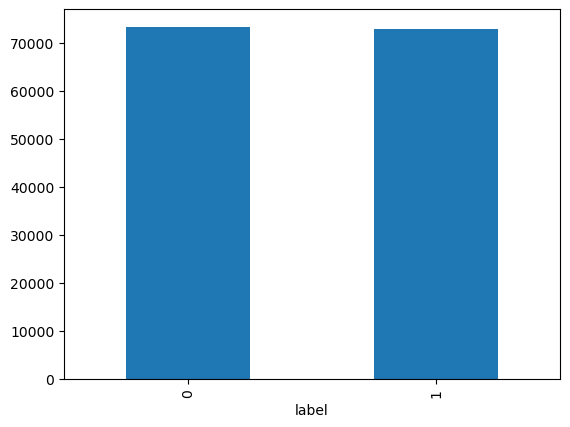

In [237]:
train_data['label'].value_counts().plot(kind='bar')

In [238]:
print(train_data.groupby('label').size().reset_index(name='count'))

   label  count
0      0  73342
1      1  72841


In [239]:
print(train_data.isnull().values.any())

True


In [240]:
print(train_data.isnull().sum())

id          0
document    1
label       0
dtype: int64


In [241]:
train_data[train_data.document.isnull()]

,id,document,label
25857,2172111,NaN,1


In [242]:
train_data = train_data.dropna(how = 'any')
print(train_data.isnull().values.any())

False


In [243]:
print(len(train_data))

146182


In [244]:
# 한글과 공백을 제외하고 모두 제거
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", regex=True)
train_data[:5]

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


In [245]:
train_data['document'] = train_data['document'].str.replace('^ +', '', regex = True)
train_data['document'].replace('', np.nan, inplace = True)
print(train_data.isnull().sum())

id            0
document    789
label         0
dtype: int64


/var/folders/py/xgf_87rd5nz9rsbc143wp9qc0000gn/T/ipykernel_6315/2928209278.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data['document'].replace('', np.nan, inplace = True)


In [246]:
train_data.loc[train_data.document.isnull()][:5]

,id,document,label
404,4221289,NaN,0
412,9509970,NaN,1
470,10147571,NaN,1
584,7117896,NaN,0
593,6478189,NaN,0


In [247]:
train_data = train_data.dropna(how = 'any')
print(len(train_data))

145393


In [248]:
test_data.drop_duplicates(subset = ['document'], inplace = True)
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "", regex=True)
test_data['document'] = test_data['document'].str.replace('^ +', '', regex = True)
test_data['document'].replace('', np.nan, inplace = True)
test_data = test_data.dropna(how = 'any')
print('전처리 후 테스트용 샘플의 개수: ', len(test_data))

전처리 후 테스트용 샘플의 개수:  48852


/var/folders/py/xgf_87rd5nz9rsbc143wp9qc0000gn/T/ipykernel_6315/921078627.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_data['document'].replace('', np.nan, inplace = True)


In [249]:
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']

In [250]:
mecab = Mecab()
mecab.morphs('와 이런 것도 영화라고 차라리 뮤직비디오를 만드는 게 나을 뻔')

['와',
 '이런',
 '것',
 '도',
 '영화',
 '라고',
 '차라리',
 '뮤직',
 '비디오',
 '를',
 '만드',
 '는',
 '게',
 '나을',
 '뻔']

In [251]:
X_train = []
for sentence in tqdm(train_data['document']):
    tokenized_sentence = mecab.morphs(sentence)
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords]
    X_train.append(stopwords_removed_sentence)
print(X_train[:3])

100%|██████████| 145393/145393 [00:02<00:00, 49449.40it/s]

[['아', '더', '빙', '진짜', '짜증', '나', '네요', '목소리'], ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍', '않', '구나'], ['너무', '재', '밓었다그래서보는것을추천한다']]


In [252]:
print(X_train[:5])

[['아', '더', '빙', '진짜', '짜증', '나', '네요', '목소리'], ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍', '않', '구나'], ['너무', '재', '밓었다그래서보는것을추천한다'], ['교도소', '이야기', '구먼', '솔직히', '재미', '없', '평점', '조정'], ['사이몬페그', '익살', '스런', '연기', '돋보였', '던', '영화', '스파이더맨', '에서', '늙', '어', '보이', '기', '만', '했', '던', '커스틴', '던스트', '너무나', '이뻐', '보였']]


In [253]:
X_test = []
for sentence in tqdm(test_data['document']):
    tokenized_sentence = mecab.morphs(sentence)
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords]
    X_test.append(stopwords_removed_sentence)

100%|██████████| 48852/48852 [00:01<00:00, 40483.70it/s]


In [254]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=0, stratify=y_train)

In [255]:
print('--------훈련 데이터의 비율-----------')
print(f'부정 리뷰 = {round(np.sum(y_train==0)/len(y_train) * 100,3)}%')
print(f'긍정 리뷰 = {round(np.count_nonzero(y_train)/len(y_train) * 100,3)}%')
print('--------검증 데이터의 비율-----------')
print(f'부정 리뷰 = {round(np.sum(y_valid==0)/len(y_valid) * 100,3)}%')
print(f'긍정 리뷰 = {round(np.count_nonzero(y_valid)/len(y_valid) * 100,3)}%')
print('--------테스트 데이터의 비율-----------')
print(f'부정 리뷰 = {round(np.sum(y_test==0)/len(y_test) * 100,3)}%')
print(f'긍정 리뷰 = {round(np.count_nonzero(y_test)/len(y_test) * 100,3)}%')

--------훈련 데이터의 비율-----------
부정 리뷰 = 50.238%
긍정 리뷰 = 49.762%
--------검증 데이터의 비율-----------
부정 리뷰 = 50.239%
긍정 리뷰 = 49.761%
--------테스트 데이터의 비율-----------
부정 리뷰 = 49.808%
긍정 리뷰 = 50.192%


In [256]:
word_list = []
for sent in X_train:
    for word in sent:
        word_list.append(word)
word_counts = Counter(word_list)
print('총 단어의 개수: ', len(word_counts))

총 단어의 개수:  45296


In [257]:
print('훈련 데이터에서의 단어 영화의 등장 횟수 :', word_counts['영화'])
print('훈련 데이터에서의 단어 공감의 등장 횟수 :', word_counts['공감'])

훈련 데이터에서의 단어 영화의 등장 횟수 : 45791
훈련 데이터에서의 단어 공감의 등장 횟수 : 756


In [258]:
vocab = sorted(word_counts, key=word_counts.get, reverse=True)
print('등장 빈도수 상위 10개 단어')
print(vocab[:10])

등장 빈도수 상위 10개 단어
['영화', '보', '있', '없', '좋', '나', '었', '만', '는데', '너무']


In [259]:
threshold = 3
total_cnt = len(word_counts) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 45296
등장 빈도가 2번 이하인 희귀 단어의 수: 26104
단어 집합에서 희귀 단어의 비율: 57.62981278700106
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 2.2768269150096483


In [260]:
vocab_size = total_cnt - rare_cnt
vocab = vocab[:vocab_size]
print('단어 집합의 크기: ', len(vocab))

단어 집합의 크기:  19192


In [261]:
word_to_index = {}
word_to_index['<PAD>'] = 0
word_to_index['<UNK>'] = 1

In [262]:
for index, word in enumerate(vocab):
    word_to_index[word] = index + 2

vocab_size = len(word_to_index)
print('패딩 토큰과 UNK 토큰을 고려한 단어 집합의 크기: ', vocab_size)

패딩 토큰과 UNK 토큰을 고려한 단어 집합의 크기:  19194


In [263]:
print('단어 와 맵핑되는 정수 :', word_to_index['<PAD>'])
print('단어 와 맵핑되는 정수 :', word_to_index['<UNK>'])
print('단어 영화와 맵핑되는 정수 :', word_to_index['영화'])

단어 와 맵핑되는 정수 : 0
단어 와 맵핑되는 정수 : 1
단어 영화와 맵핑되는 정수 : 2


In [264]:
def text_to_sequences(tokenized_X_data, word_to_index):
    encoded_X_data = []
    for sent in tokenized_X_data:
        index_sequences = []
        for word in sent:
            try:
                index_sequences.append(word_to_index[word])
            except KeyError:
                index_sequences.append(word_to_index['<UNK>'])
        encoded_X_data.append(index_sequences)
    return encoded_X_data

In [265]:
encoded_X_train = text_to_sequences(X_train, word_to_index)
encoded_X_valid = text_to_sequences(X_valid, word_to_index)
encoded_X_test = text_to_sequences(X_test, word_to_index)

In [266]:
for sent in encoded_X_train[:2]:
    print(sent)

[924, 1866, 128, 7, 80, 48, 34]
[2415, 3138, 4, 2095, 422, 87, 5768, 19, 307]


In [267]:
index_to_word = {}
for key, value in word_to_index.items():
    index_to_word[value] = key

In [268]:
decoded_sample = [index_to_word[word] for word in encoded_X_train[0]]
print('기존의 첫번째 샘플 : ', X_train[0])
print('복원된 첫번째 샘플 : ', decoded_sample)

기존의 첫번째 샘플 :  ['이야', '어쩜', '이렇게', '나', '지루', '할', '수']
복원된 첫번째 샘플 :  ['이야', '어쩜', '이렇게', '나', '지루', '할', '수']


리뷰의 최대 길이:  74
리뷰의 평균 길이:  12.296714067094245


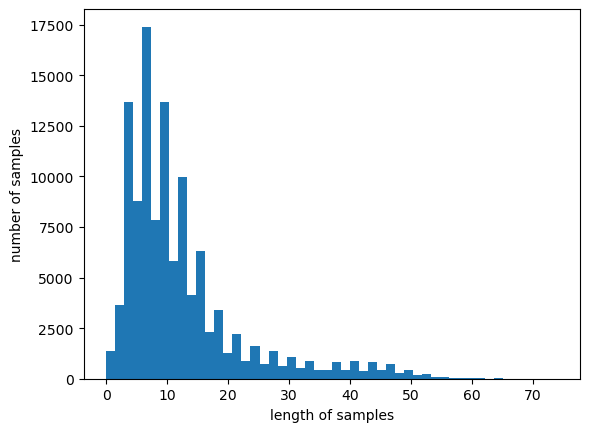

In [269]:
print('리뷰의 최대 길이: ', max(len(review) for review in encoded_X_train))
print('리뷰의 평균 길이: ', sum(map(len, encoded_X_train)) / len(encoded_X_train))

plt.hist([len(review) for review in encoded_X_train], bins = 50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [270]:
def below_threshold_len(max_len, nested_list):
    count = 0
    for sentence in nested_list:
        if len(sentence) <= max_len:
            count += 1
    print('전체 샘플 주 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list)) * 100))

In [271]:
max_len = 30
below_threshold_len(max_len, encoded_X_train)

전체 샘플 주 길이가 30 이하인 샘플의 비율: 92.49703389101914


In [272]:
def pad_sequences(sentences, max_len):
    features = np.zeros((len(sentences), max_len), dtype = int)
    for index, sentence in enumerate(sentences):
        if len(sentence) != 0:
            features[index, :len(sentence)] = np.array(sentence)[:max_len]
    return features

In [273]:
padded_X_train = pad_sequences(encoded_X_train, max_len)
padded_X_valid = pad_sequences(encoded_X_valid, max_len)
padded_X_test = pad_sequences(encoded_X_test, max_len)

print('훈련 데이터의 크기 :', padded_X_train.shape)
print('검증 데이터의 크기 :', padded_X_valid.shape)
print('테스트 데이터의 크기 :', padded_X_test.shape)

훈련 데이터의 크기 : (116314, 30)
검증 데이터의 크기 : (29079, 30)
테스트 데이터의 크기 : (48852, 30)


In [274]:
print('첫번째 샘플의 길이 : ', len(padded_X_train[0]))
print('첫번째 샘플 : ', padded_X_train[0])

첫번째 샘플의 길이 :  30
첫번째 샘플 :  [ 924 1866  128    7   80   48   34    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


In [275]:
import torch
import torch.nn as nn
import torch.nn.functional as F

USE_MPS = torch.backends.mps.is_available()
device = torch.device('mps' if USE_MPS else 'cpu')
print('cpu와 mps중 다음 기기로 학습함: ', device)

cpu와 mps중 다음 기기로 학습함:  mps


In [276]:
train_label_tensor = torch.tensor(np.array(y_train))
valid_label_tensor = torch.tensor(np.array(y_valid))
test_label_tensor = torch.tensor(np.array(y_test))
print(train_label_tensor[:5])

tensor([0, 1, 1, 1, 1])


In [277]:
class TextClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(TextClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # x: (batch_size, seq_length)
        embedded = self.embedding(x)  # (batch_size, seq_length, embedding_dim)

        # LSTM은 (hidden state, cell state)의 튜플을 반환합니다
        lstm_out, (hidden, cell) = self.lstm(embedded)  # lstm_out: (batch_size, seq_length, hidden_dim), hidden: (1, batch_size, hidden_dim)

        last_hidden = hidden.squeeze(0)  # (batch_size, hidden_dim)
        logits = self.fc(last_hidden)  # (batch_size, output_dim)
        return logits

In [278]:

encoded_train = torch.tensor(padded_X_train).to(torch.int64)
train_dataset = torch.utils.data.TensorDataset(encoded_train, train_label_tensor)
train_dataloader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=32)

encoded_test = torch.tensor(padded_X_test).to(torch.int64)
test_dataset = torch.utils.data.TensorDataset(encoded_test, test_label_tensor)
test_dataloader = torch.utils.data.DataLoader(test_dataset, shuffle=True, batch_size=1)

encoded_valid = torch.tensor(padded_X_valid).to(torch.int64)
valid_dataset = torch.utils.data.TensorDataset(encoded_valid, valid_label_tensor)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, shuffle=True, batch_size=1)

In [279]:
total_batch = len(train_dataloader)
print("총 배치의 수 : {}".format(total_batch))

총 배치의 수 : 3635


In [280]:
embedding_dim = 100
hidden_dim = 128
output_dim = 2
learning_rate = 0.01
num_epochs = 10

model = TextClassifier(vocab_size, embedding_dim, hidden_dim, output_dim)
model.to(device)

TextClassifier(
  (embedding): Embedding(19194, 100)
  (lstm): LSTM(100, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

In [281]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [282]:
def calculate_accuracy(logits, labels):
    predicted = torch.argmax(logits, dim=1)
    correct = (predicted == labels).sum().item()
    total = labels.size(0)
    accuracy = correct / total
    return accuracy

In [283]:
def evaluate(model, valid_dataloader, criterion, device):
    val_loss = 0
    val_correct = 0
    val_total = 0

    model.eval()
    with torch.no_grad():
        # 데이터로더로부터 배치 크기만큼의 데이터를 연속으로 로드
        for batch_X, batch_y in valid_dataloader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            # 모델의 예측값
            logits = model(batch_X)

            # 손실을 계산
            loss = criterion(logits, batch_y)

            # 정확도와 손실을 계산함
            val_loss += loss.item()
            val_correct += calculate_accuracy(logits, batch_y) * batch_y.size(0)
            val_total += batch_y.size(0)

    val_accuracy = val_correct / val_total
    val_loss /= len(valid_dataloader)

    return val_loss, val_accuracy

In [284]:
# Training loop
best_val_loss = float('inf')

# Training loop
for epoch in range(num_epochs):
    # Training
    train_loss = 0
    train_correct = 0
    train_total = 0
    model.train()
    for batch_X, batch_y in train_dataloader:

        # batch_X.shape == (batch_size, max_len)
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        logits = model(batch_X)

        # Compute loss
        loss = criterion(logits, batch_y)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate training accuracy and loss
        train_loss += loss.item()
        train_correct += calculate_accuracy(logits, batch_y) * batch_y.size(0)
        train_total += batch_y.size(0)

    train_accuracy = train_correct / train_total
    train_loss /= len(train_dataloader)

    # Validation
    val_loss, val_accuracy = evaluate(model, valid_dataloader, criterion, device)

    print(f'Epoch {epoch+1}/{num_epochs}:')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

    # 검증 손실이 최소일 때 체크포인트 저장
    if val_loss < best_val_loss:
        print(f'Validation loss improved from {best_val_loss:.4f} to {val_loss:.4f}. 체크포인트를 저장합니다.')
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model_checkpoint.pth')

Epoch 1/10:
Train Loss: 0.4742, Train Accuracy: 0.7458
Validation Loss: 0.3629, Validation Accuracy: 0.8387
Validation loss improved from inf to 0.3629. 체크포인트를 저장합니다.
Epoch 2/10:
Train Loss: 0.3185, Train Accuracy: 0.8615
Validation Loss: 0.3451, Validation Accuracy: 0.8501
Validation loss improved from 0.3629 to 0.3451. 체크포인트를 저장합니다.
Epoch 3/10:
Train Loss: 0.2572, Train Accuracy: 0.8930
Validation Loss: 0.3449, Validation Accuracy: 0.8530
Validation loss improved from 0.3451 to 0.3449. 체크포인트를 저장합니다.
Epoch 4/10:
Train Loss: 0.2006, Train Accuracy: 0.9196
Validation Loss: 0.3705, Validation Accuracy: 0.8508
Epoch 5/10:
Train Loss: 0.1500, Train Accuracy: 0.9431
Validation Loss: 0.4228, Validation Accuracy: 0.8486
Epoch 6/10:
Train Loss: 0.1112, Train Accuracy: 0.9598
Validation Loss: 0.4799, Validation Accuracy: 0.8411
Epoch 7/10:
Train Loss: 0.0846, Train Accuracy: 0.9705
Validation Loss: 0.5467, Validation Accuracy: 0.8427
Epoch 8/10:
Train Loss: 0.0677, Train Accuracy: 0.9773
Valida

In [285]:
model.load_state_dict(torch.load('best_model_checkpoint.pth'))

model.to(device)

val_loss, val_accuracy = evaluate(model, valid_dataloader, criterion, device)

print(f'Best model validation loss: {val_loss: .4f}')
print(f'Best model validation accuracy: {val_accuracy:.4f}')

/var/folders/py/xgf_87rd5nz9rsbc143wp9qc0000gn/T/ipykernel_6315/538150772.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model_ch

Best model validation loss:  0.3449
Best model validation accuracy: 0.8530


In [286]:
tests_loss, test_accracy = evaluate(model, test_dataloader, criterion, device)

print(f'Best model test loss: {tests_loss: .4f}')
print(f'Best model test accuracy: {test_accracy:.4f}')

Best model test loss:  0.3476
Best model test accuracy: 0.8522


In [287]:
index_to_tag = {0 : '부정', 1: '긍정'}

In [288]:
def predict(text, model, word_to_index, index_to_tag):
    model.eval()

    tokens = mecab.morphs(text)
    tokens = [word for word in tokens if not word in stopwords]
    token_indices = [word_to_index.get(token, 1) for token in tokens]

    input_tensor = torch.tensor([token_indices], dtype = torch.long).to(device)

    with torch.no_grad():
        logits = model(input_tensor)

    predicted_index = torch.argmax(logits, dim=1)

    predicted_tag = index_to_tag[predicted_index.item()]
    return predicted_tag

In [291]:
test_input = '이 영화 개꿀잼 ㅋㅋㅋ'
predict(test_input, model, word_to_index, index_to_tag)

'긍정'

이 영화 개꿀잼 ㅋㅋㅋ
